In [61]:
import numpy as np
import random
import torch
import torch.nn as nn
import gym
import time
from tqdm import tqdm
from torch.distributions import Normal

import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns

sns.set()

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 6.0)

In [187]:
def save_frames_as_gif(frames, path='./', filename='gym_animation.gif', fps=30):

    plt.figure(figsize=(frames[0].shape[1] / 50.0, frames[0].shape[0] / 50.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    anim.save(path + filename, writer='imagemagick', fps=fps)

In [394]:
class PPO(nn.Module):
    def __init__(self, state_dim, action_dim, gamma=0.999, batch_size=128, 
                 epsilon=0.1, epoch_n=30, pi_lr=3e-4, v_lr=3e-4):

        super().__init__()
        
        self.state_dim = state_dim
        self.action_dim = action_dim

        self.pi_model = nn.Sequential(nn.Linear(self.state_dim, 128), nn.ReLU(),
                                      nn.Linear(128, 128), nn.ReLU(),
                                      nn.Linear(128, 2 * self.action_dim), nn.Tanh())
        
        self.v_model = nn.Sequential(nn.Linear(self.state_dim, 128), nn.ReLU(),
                                     nn.Linear(128, 128), nn.ReLU(),
                                     nn.Linear(128, 1))
        
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.epoch_n = epoch_n
        self.pi_optimizer = torch.optim.Adam(self.pi_model.parameters(), lr=pi_lr)
        self.v_optimizer = torch.optim.Adam(self.v_model.parameters(), lr=v_lr)

    def get_action(self, state):
        # print(self.pi_model(torch.FloatTensor(state)).shape)
        mean, log_std = self.pi_model(torch.FloatTensor(state)).reshape(2, -1, self.action_dim)
        # mean, log_std = self.pi_model(torch.FloatTensor(state))
        dist = Normal(mean, torch.exp(log_std))
        action = dist.sample()
        return action.numpy().reshape(self.action_dim)

    def fit(self, states, actions, rewards, dones, advantage='default'):
        
        states, actions, rewards, dones = map(np.array, [states, actions, rewards, dones])
        rewards, dones = rewards.reshape(-1, 1), dones.reshape(-1, 1)

        # print(states.shape, actions.shape)

        next_states = np.zeros_like(states)
        next_states[:-1] = states[1:]

        returns = np.zeros(rewards.shape)
        returns[-1] = rewards[-1]
        for t in range(returns.shape[0] - 2, -1, -1):
            returns[t] = rewards[t] + (1 - dones[t]) * self.gamma * returns[t + 1]

        states, next_states, actions, rewards, returns, dones = map(torch.FloatTensor, [states, next_states, actions, rewards, returns, dones])

        logits = self.pi_model(states)
        mean, log_std = logits[:, :self.action_dim], logits[:, self.action_dim:]
        
        #print(self.pi_model(states).shape)
        #print(mean.shape, log_std.shape)
        #print(mean, log_std)

        # print(self.pi_model(states).shape)
        # print(mean[:5], log_std[:5])

        #mean, log_std = self.pi_model(states).T
        #mean, log_std = mean.unsqueeze(1), log_std.unsqueeze(1)
        #print(mean.shape, log_std.shape)
        #print(mean, log_std)

        # return

        # print(mean.shape, log_std.shape)

        dist = Normal(mean, torch.exp(log_std))
        old_log_probs = dist.log_prob(actions).detach()

        # print(old_log_probs.shape)

        for epoch in range(self.epoch_n):
            
            idxs = np.random.permutation(returns.shape[0])
            for i in range(0, returns.shape[0], self.batch_size):
                b_idxs = idxs[i: i + self.batch_size]
                b_states = states[b_idxs]
                b_next_states = next_states[b_idxs]
                b_dones = dones[b_idxs]
                b_actions = actions[b_idxs]
                b_rewards = rewards[b_idxs]
                b_returns = returns[b_idxs]
                b_old_log_probs = old_log_probs[b_idxs]

                if advantage == 'default':
                    b_advantage = b_returns.detach() - self.v_model(b_states)

                if advantage == 'bellman':
                    b_advantage = b_rewards.detach() + (1 - b_dones.detach()) * self.gamma * self.v_model(b_next_states.detach()) - self.v_model(b_states) 

                # b_mean, b_log_std = self.pi_model(b_states).T
                # b_mean, b_log_std = b_mean.unsqueeze(1), b_log_std.unsqueeze(1)
                #print(b_mean.shape, b_log_std.shape)
                #print(b_mean, b_log_std)
                    
                b_logits = self.pi_model(b_states)
                b_mean, b_log_std = b_logits[:, :self.action_dim], b_logits[:, self.action_dim:]
                #print(b_mean.shape, b_log_std.shape)
                #print(b_mean, b_log_std)

                b_dist = Normal(b_mean, torch.exp(b_log_std))
                b_new_log_probs = b_dist.log_prob(b_actions)
    
                b_ratio = torch.exp(b_new_log_probs - b_old_log_probs)
                pi_loss_1 = b_ratio * b_advantage.detach()
                pi_loss_2 = torch.clamp(b_ratio, 1. - self.epsilon,  1. + self.epsilon) * b_advantage.detach()
                pi_loss = - torch.mean(torch.min(pi_loss_1, pi_loss_2))
                
                pi_loss.backward()
                self.pi_optimizer.step()
                self.pi_optimizer.zero_grad()
                
                v_loss = torch.mean(b_advantage ** 2)
    
                v_loss.backward()
                self.v_optimizer.step()
                self.v_optimizer.zero_grad()


In [395]:
def get_trajectory(env, agent, trajectory_len=200, visualize=False, filename='gym_animation.gif'):
    trajectory = {'states':[], 'actions': [], 'rewards': [], 'dones': []}
    
    state = env.reset()

    frames = []
    for _ in range(trajectory_len):

        trajectory['states'].append(state)

        action = agent.get_action(state)
        trajectory['actions'].append(action)

        next_state, reward, done, _ = env.step(action)
        trajectory['rewards'].append(reward)
        trajectory['dones'].append(done)

        state = next_state

        if done:
            break

        if visualize:
            frames.append(env.render(mode="rgb_array"))

    if visualize:
        save_frames_as_gif(frames, filename=filename)

    return trajectory

In [396]:
def train(env, agent, episode_n=50, trajectory_n=20, trajectory_len=200, advantage='default'):
    total_rewards = []
    for episode in range(episode_n):

        states, actions, rewards, dones = [], [], [], []

        for i in range(trajectory_n):

            trajectory = get_trajectory(env, agent, trajectory_len)

            states.extend(trajectory['states'])
            actions.extend(trajectory['actions'])
            rewards.extend(trajectory['rewards'])
            dones.extend(trajectory['dones'])

            total_rewards.append(np.sum(trajectory['rewards']))

        print(f"{episode}: mean reward = {np.mean(total_rewards[-trajectory_n:])}")

        agent.fit(states, actions, rewards, dones, advantage)

    return total_rewards

In [464]:
def validation(env, agent, validation_n, trajectory_len=200):
    total_rewards = []
    for _ in range(validation_n):
        trajectory = get_trajectory(env, agent, trajectory_len)
        total_rewards.append(np.sum(trajectory['rewards']))

    return np.mean(total_rewards)

## Задание 2

### Lander

In [397]:
env = gym.make("LunarLander-v2", continuous=True)

In [398]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

In [399]:
env.action_space

Box(-1.0, 1.0, (2,), float32)

In [405]:
agent = PPO(state_dim, action_dim)

In [444]:
episode_n = 20
trajectory_n = 10
agent.epoch_n = 20

In [407]:
#history = []

In [461]:
rewards = train(env, agent, episode_n, trajectory_n, trajectory_len=200, advantage='default')
history.extend(rewards)

0: mean reward = 127.83355946566004
1: mean reward = 147.16247168291565
2: mean reward = 140.02472660542398
3: mean reward = 115.1906697928695
4: mean reward = 120.44834518840801
5: mean reward = 138.21705613429566
6: mean reward = 126.56586329603405
7: mean reward = 63.66014188147649
8: mean reward = 83.54464063570245
9: mean reward = 114.89785672371781
10: mean reward = 120.2977658231999
11: mean reward = 129.81759229437725
12: mean reward = 125.0317937444042
13: mean reward = 56.54332764422495
14: mean reward = 141.22571905662977
15: mean reward = 54.401422485087735
16: mean reward = 136.34390017699087
17: mean reward = 46.47824482744219
18: mean reward = 124.68632939797044
19: mean reward = 123.17983716278752


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


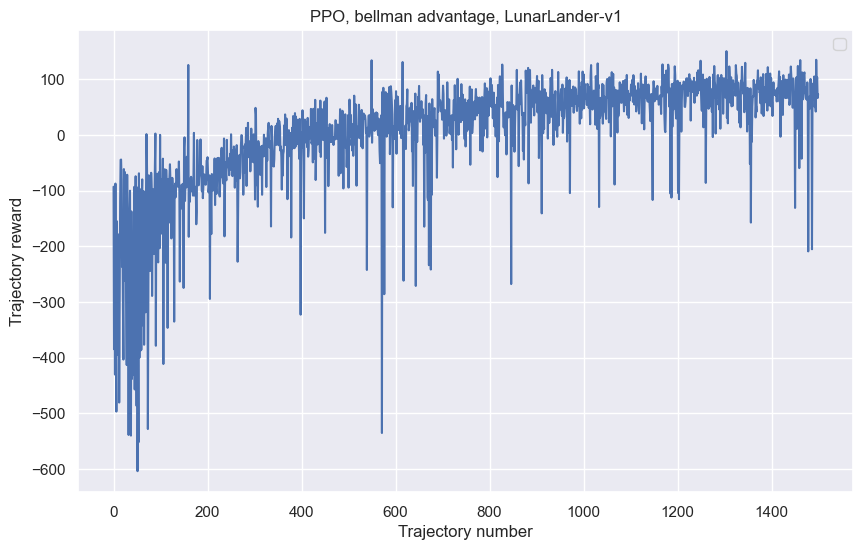

In [463]:
plt.title('PPO, bellman advantage, LunarLander-v1')
plt.xlabel('Trajectory number')
plt.ylabel('Trajectory reward')
plt.legend()

plt.plot(history[:-500])

In [460]:
traj = get_trajectory(env, agent, trajectory_len=500, visualize=False)
np.sum(traj['rewards'])

93.8246410073211

In [466]:
validation_n = 100

validation_score = validation(env, agent, validation_n=validation_n, trajectory_len=200)
print(f'PPO, bellman advantage, validation_score: {validation_score}')

PPO, bellman advantage, validation_score: 109.5668648926394


### Pend

In [324]:
env = gym.make("Pendulum-v1")

c:\Users\никита\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\utils\env_checker.py:200: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


In [325]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

In [326]:
agent = PPO(state_dim, action_dim)

In [327]:
episode_n = 20
trajectory_n = 20
agent.epoch_n = 30

In [328]:
rewards = train(env, agent, episode_n, trajectory_n, trajectory_len=200, advantage='default')

0: mean reward = -1177.8563995733302
1: mean reward = -1102.1876689051783
2: mean reward = -1135.7212787353217
3: mean reward = -1040.2079563610519
4: mean reward = -896.2152330020119
5: mean reward = -790.3223970046457
6: mean reward = -655.9342698542912
7: mean reward = -452.38838978537444
8: mean reward = -317.15668915692873
9: mean reward = -276.61095222901764
10: mean reward = -268.4627721641469
11: mean reward = -213.48856758515188
12: mean reward = -194.90732651446484
13: mean reward = -198.75091210919578


KeyboardInterrupt: 

In [ ]:
state = env.reset()
agent.get_action(state)

array([0.11150053], dtype=float32)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


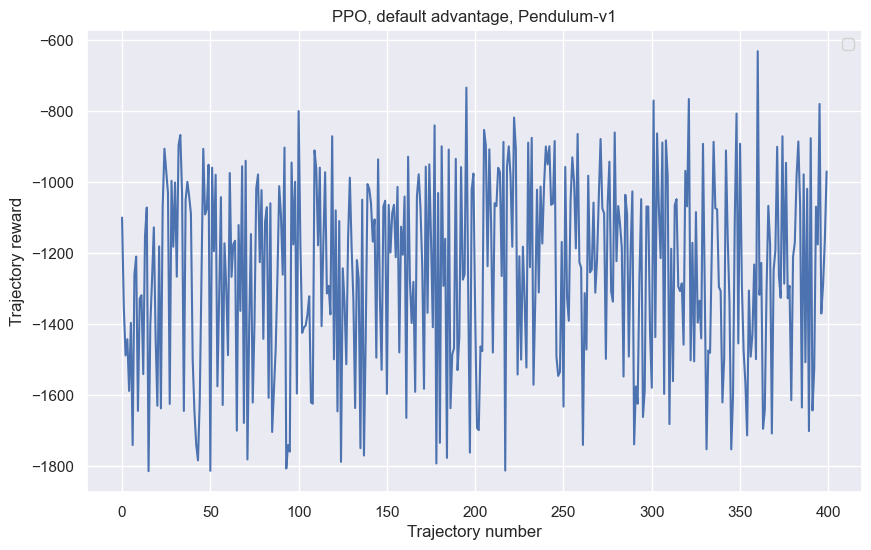

In [261]:
plt.title('PPO, default advantage, Pendulum-v1')
plt.xlabel('Trajectory number')
plt.ylabel('Trajectory reward')
plt.legend()

plt.plot(rewards)